# Openmc Overview

The purpose of this notebook is to provide an introduction to the capabilities of OpenMC.  The coverage is intended to provide a fairly deep look at a geometrically simple problem of an infinite pin-cell. The basic topics to be covered will be:

1. material specification
2. geometry description
3. tally specification
4. control parameter specification

The analysis will include a simple criticality calculation and neutron flux energy spectrum measurement.  This will be followed by a somewhat more elaborate treatment of fuel material specification and some exploration into the consequences of one or two important details of fuel material composition.  A burn-up analysis will also be conducted to demonstrate the code capabilities and get a first look at the evolution of important fission products.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import openmc

## Material Specification

First we will define the fuel

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U",1,percent_type="ao", enrichment=4.25,enrichment_type='wo')
fuel.add_element("O",2)
fuel.set_density("g/cc",10.4)

Documentation on the OpenMC Material object, along with all other OpenMC features can be found [here](https://docs.openmc.org/en/stable/)

Next we define the cladding

In [3]:
clad = openmc.Material(name='clad')
clad.add_element("Zr",1)
clad.set_density('g/cc',6.0)

and water moderator.

In [4]:
water = openmc.Material(name='water')
water.add_element('O',1)
water.add_element('H',2)
water.set_density('g/cc',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

The last line adds some additional physics.  The kinematics of neutron scattering interactions depends on whether the target atom is *free* or *bound in a molecule*.  This dependence is stronger for light atoms.  The required modification to scattering interactions is captured in, so called, $S(\alpha,\beta)$ relation.  In the code block above we "add" the $S(\alpha,\beta)$ relation for hydrogen bound in water.

Any time you have a significant atom fraction of light atoms bound in molecules you should be looking to add an appropriate $S(\alpha,\beta)$.

These are all of the materials that we are going to include for this simple model.  In order for the OpenMC neutron transport code to use the materials, they need to be written to an XML file called 'materials.xml'. The OpenMC Python interface provides tools for doing this in the `Materials` object.

In [5]:
materials = openmc.Materials()
materials += [fuel, clad, water]
materials.export_to_xml()

## Geometry

Next we will define the geometry.  As a first example we will create an infinite array of infinitely long pin cells.

The geometry definition process we will follow for this example will comprise these steps:

1. Definition of surfaces (in some cases including boundary conditions)
2. Definition of regions which are collections of half-spaces
3. Definition of cells which combines half-spaces with materials; and
4. Organization of cells into a universe.


### Surface Definitions

In [6]:
R_fo = 0.39 # cm, fuel outer radius
R_ci = 0.40 # cm, clad inner radius
R_co = 0.46 # cm, clad outer radius
Pitch = 1.26 # cm, distance between centerline of adjacent cells

fuel_outer_radius = openmc.ZCylinder(r=R_fo)
clad_inner_radius = openmc.ZCylinder(r=R_ci)
clad_outer_radius = openmc.ZCylinder(r=R_co)

left = openmc.XPlane(x0=-Pitch/2., boundary_type='reflective')
right = openmc.XPlane(x0=Pitch/2., boundary_type='reflective')
bottom = openmc.YPlane(y0=-Pitch/2., boundary_type='reflective')
top = openmc.YPlane(y0=Pitch/2., boundary_type='reflective')

### Definition of Regions

In [7]:
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

water_region = +left & -right & +bottom & -top & +clad_outer_radius

### Definition of Cells

In [9]:
fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = fuel
fuel_cell.region = fuel_region

gap_cell = openmc.Cell(name='gap')
gap_cell.region = gap_region
gap_cell.fill = None # no material = void

clad_cell = openmc.Cell(name='clad')
clad_cell.region = clad_region
clad_cell.fill = clad

water_cell = openmc.Cell(name='moderator')
water_cell.region = water_region
water_cell.fill = water



### Definition of a Universe

In [10]:
root_universe = openmc.Universe(cells=(fuel_cell,gap_cell,clad_cell,water_cell))

geometry = openmc.Geometry()
geometry.root_universe = root_universe
geometry.export_to_xml()

### Plot the Geometry

In [11]:
colors = {}
colors[fuel] = 'yellow'
colors[clad] = 'grey'
colors[water] = 'blue'

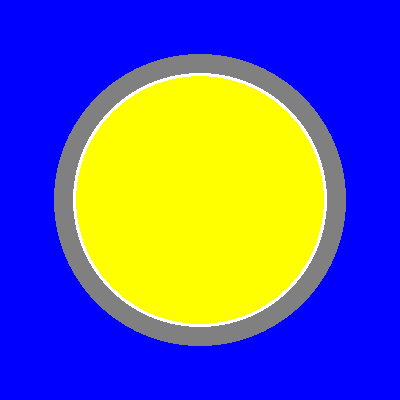

In [12]:
p = openmc.Plot()
p.width = [Pitch,Pitch]
p.pixels = [400,400]
p.origin = [0.0, 0.0, 0.0]
p.color_by = 'material'
p.colors = colors

openmc.plot_inline(p)


Now that the geometry and material composition of the reactor is specified, we need to tell OpenMC what information we hope to get out of the model.  This is done through *tallies*.

### Re-do Geometry with a Finite Pincell

In [13]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

materials.export_to_xml();
geometry.export_to_xml();


## Tally Specification

In [14]:
# flux energy spectrum in fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

energy_bins = np.logspace(-3,7,num=1001)
energy_filter = openmc.EnergyFilter(values=energy_bins)

flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux']
flux_tally.filters = [cell_filter,energy_filter]


tallies = openmc.Tallies([flux_tally])

tallies.export_to_xml()

## Settings

In [16]:
settings = openmc.Settings()
settings.batches = 300
settings.inactive = 50
settings.particles = 20000

point = openmc.stats.Point((0,0,0))
source = openmc.Source(space=point)

settings.source = source

settings.export_to_xml()

In [17]:
import os

num_threads_des = 12  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS

openmc.run(threads = num_threads)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      137/1    1.42577    1.43811 +/- 0.00130
      138/1    1.43196    1.43804 +/- 0.00129
      139/1    1.45369    1.43822 +/- 0.00128
      140/1    1.42018    1.43802 +/- 0.00129
      141/1    1.43384    1.43797 +/- 0.00127
      142/1    1.42732    1.43786 +/- 0.00126
      143/1    1.45958    1.43809 +/- 0.00127
      144/1    1.44053    1.43812 +/- 0.00126
      145/1    1.44397    1.43818 +/- 0.00125
      146/1    1.44422    1.43824 +/- 0.00124
      147/1    1.45192    1.43838 +/- 0.00123
      148/1    1.43275    1.43833 +/- 0.00122
      149/1    1.42514    1.43819 +/- 0.00121
      150/1    1.41707    1.43798 +/- 0.00122
      151/1    1.40226    1.43763 +/- 0.00126
      152/1    1.45431    1.43779 +/- 0.00126
      153/1    1.42732    1.43769 +/- 0.00125
      154/1    1.42980    1.43761 +/- 0.00124
      155/1    1.44908    1.43772 +/- 0.00123
      156/1    1.43059    1.43765 +/- 0.00122
      157/1    1.42394    1.43753 +/- 0.00122
      158/1    1.43665    1.43752 

### Access Tally and Plot Flux Spectrum

In [16]:
sp = openmc.StatePoint('statepoint.300.h5')
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

Text(0, 0.5, 'flux [n/cm**2-s]')

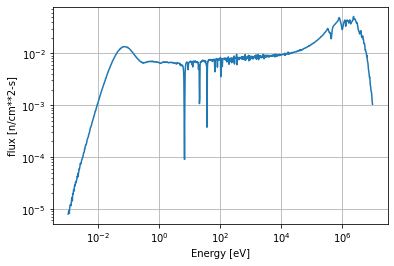

In [17]:
flux = sp.get_tally(name='flux')
flux_df = flux.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm**2-s]')


Notice the deep "pits" in the flux energy distribution.  It is worthwhile to investigate why those features exist.  To do so, more tallies could be added; specifically to measure capture - in total, as well as by specific isotopes. 

## Bonu Section: Depletion

In [18]:
import openmc.deplete

chain = openmc.deplete.Chain.from_xml("chain_endfb71_pwr.xml")


In [19]:
chain.nuclide_dict

OrderedDict([('H1', 0),
             ('H2', 1),
             ('H3', 2),
             ('H4', 3),
             ('H5', 4),
             ('H6', 5),
             ('H7', 6),
             ('He3', 7),
             ('He4', 8),
             ('He5', 9),
             ('He6', 10),
             ('He7', 11),
             ('He8', 12),
             ('He9', 13),
             ('He10', 14),
             ('Li4', 15),
             ('Li5', 16),
             ('Li6', 17),
             ('Li7', 18),
             ('Li8', 19),
             ('Li9', 20),
             ('Li10', 21),
             ('Li11', 22),
             ('Li12', 23),
             ('Be5', 24),
             ('Be6', 25),
             ('Be8', 26),
             ('Be9', 27),
             ('Be10', 28),
             ('Be11', 29),
             ('Be12', 30),
             ('Be13', 31),
             ('Be14', 32),
             ('Be15', 33),
             ('Be16', 34),
             ('B6', 35),
             ('B7', 36),
             ('B8', 37),
             ('B9', 3

In [ ]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")

power = 1e4;
days = 24*3600; # number of seconds in a day

time_steps = [0.1*days, 0.1*days, 0.1*days, 1.*days, 30*days, 30*days, 180*days]

integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power)

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################